In [1]:
#un canale

In [2]:
from NewLibraryENG import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
name_data4='2018-11-27T11-24-28MiP3 stimulation.h5'
name_data5='2018-11-27T10-40-53POP 3 BL .h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3
complete_string4='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data4
complete_string5='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data5
name_data='2019-01-24T16-00-33Pop1 24hour after.h5'
name_data_st = '2019-01-23T16-06-32Pop1 healthy cortical .h5'
name_data_BL = '2019-01-23T11-19-05PoP1 healthy cortical .h5'
name_data_24 = '2019-01-24T16-00-33Pop1 24hour after.h5'

complete_string='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_baseline/'+name_data_BL
complete_string_st='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_stimulation/'+name_data_st
complete_string_24='/Users/Gaia_1/Desktop/allh5files/healthy/healthy 24hrs later/'+name_data_24

In [3]:
data_BL = h5py.File(complete_string,'r')
data_st = h5py.File(complete_string_st,'r')
data_24 = h5py.File(complete_string_24,'r')

data=data_BL
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_BL = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings_BL.shape)

(4222000, 60)


In [4]:
data=data_st
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_st = pd.DataFrame(data = data_readings.transpose(), columns = labels)
print(readings_st.shape)

(4260000, 60)


In [5]:
data=data_24
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_24 = pd.DataFrame(data = data_readings.transpose(), columns = labels)
print(readings_24.shape)

(4228000, 60)


In [6]:
readings_BL.columns

Index([ b'47',  b'48',  b'46',  b'45',  b'38',  b'37',  b'28',  b'36',  b'27',
        b'17',  b'26',  b'16',  b'35',  b'25', b'Ref',  b'14',  b'24',  b'34',
        b'13',  b'23',  b'12',  b'22',  b'33',  b'21',  b'32',  b'31',  b'44',
        b'43',  b'41',  b'42',  b'52',  b'51',  b'53',  b'54',  b'61',  b'62',
        b'71',  b'63',  b'72',  b'82',  b'73',  b'83',  b'64',  b'74',  b'84',
        b'85',  b'75',  b'65',  b'86',  b'76',  b'87',  b'77',  b'66',  b'78',
        b'67',  b'68',  b'55',  b'56',  b'58',  b'57'],
      dtype='object', name='Label')

inizio=0
len_data=190000 #192 secondi
len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :59]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'33']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

In [7]:
inizio=500000
len_data=1000000 #192 secondi
#len_data=len(readings)
ref_BL=readings_BL[b'Ref']
ref_st=readings_st[b'Ref']
ref_24=readings_24[b'Ref']
prova_BL=readings_BL.drop([b'Ref'],axis=1)
prova_st=readings_st.drop([b'Ref'],axis=1)
prova_24=readings_24.drop([b'Ref'],axis=1)
prova_BL=prova_BL.iloc[inizio:len_data, 10:]
prova_BL=prova_BL[b'53']
prova_st=prova_st.iloc[inizio:len_data, 10:]
prova_st=prova_st[b'53']
prova_24=prova_24.iloc[inizio:len_data, 10:]
prova_24=prova_24[b'53']
ref_BL=ref_BL[inizio:len_data]
ref_st=ref_st[inizio:len_data]
ref_24=ref_24[inizio:len_data]

print(prova_BL.shape,ref_BL.shape,prova_st.shape,ref_st.shape,prova_24.shape,ref_24.shape)

(500000,) (500000,) (500000,) (500000,) (500000,) (500000,)


In [8]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_BL)
filt_prova=filtfilt(b,a,prova_BL)
f_prova = filt_prova - filt_ref
prova_BL=f_prova

filt_ref=filtfilt(b,a,ref_st)
filt_prova=filtfilt(b,a,prova_st)
f_prova = filt_prova - filt_ref
prova_st=f_prova

filt_ref=filtfilt(b,a,ref_24)
filt_prova=filtfilt(b,a,prova_24)
f_prova = filt_prova - filt_ref
prova_24=f_prova

print(prova_BL.shape,prova_st.shape,prova_24.shape)

(500000,) (500000,) (500000,)


In [9]:
threshold=5*(scipy.stats.median_abs_deviation(prova_BL))
print('threshold: ',threshold)
merger=np.concatenate((prova_BL, prova_st,prova_24), axis=0)
#pd.concat([prova_BL,prova_st,prova_24],axis=0)
merger

threshold:  120.19367932381004


array([  0.30346925, -21.53305176, -87.70463408, ..., -40.00065165,
        57.90134197,  21.29928733])

lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
#r_prova=prova.reshape(-1, 1)
#scaler = StandardScaler()
#s_prova = scaler.fit_transform(r_prova)
#prova=s_prova
#s_prova.shape

threshold=4*(scipy.stats.median_abs_deviation(prova))
threshold

# Spike detection

In [10]:
pos, neg=find_all_spikes(merger,threshold)

  0%|          | 0/1490000 [00:00<?, ?it/s]

positive spikes 61281 negative spikes 53069 detected spikes: 114350 firing rate:  762.3333333333334


BL:            
THRESH=4: fr 131 Hz (15014 pos, 40487 neg)           
THRESH=3: fr 390 Hz (72800 pos, 91948 neg)           
stim:     
THRESH=4: fr 14 Hz (2793 pos, 3261 neg)           
THRESH=3: fr 142.14 Hz (30101 pos, 30450 neg)       
24hrs:    
THRESH=4: fr 556 Hz (85496 pos, 149916 neg)            
THRESH=3: fr 1092.19 Hz (220928 pos, 240849 neg)

# Cutouts

In [11]:
c1=1
pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,merger,c1)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

positive spikes removed:  58668 negative spikes removed:  48764


pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

x=randint(1,min(len(pos_cut),len(neg_cut)))

plt.plot(savedp[x])
plt.plot(pos_cut[x])
plt.show()
#plt.plot(savedn[x])
#plt.plot(neg_cut[x])
#plt.show()

# Clustering

cluster range:  3 30
Total spikes:  2613
For 3 clusters, the silhouette score is: 0.180
For 4 clusters, the silhouette score is: 0.177
For 5 clusters, the silhouette score is: 0.183
For 6 clusters, the silhouette score is: 0.185
For 7 clusters, the silhouette score is: 0.184
For 8 clusters, the silhouette score is: 0.181
For 9 clusters, the silhouette score is: 0.183
For 10 clusters, the silhouette score is: 0.179
For 11 clusters, the silhouette score is: 0.183
For 12 clusters, the silhouette score is: 0.183
For 13 clusters, the silhouette score is: 0.175
For 14 clusters, the silhouette score is: 0.174
For 15 clusters, the silhouette score is: 0.182
For 16 clusters, the silhouette score is: 0.175
For 17 clusters, the silhouette score is: 0.171
For 18 clusters, the silhouette score is: 0.177
For 19 clusters, the silhouette score is: 0.173
For 20 clusters, the silhouette score is: 0.172
For 21 clusters, the silhouette score is: 0.178
For 22 clusters, the silhouette score is: 0.167
For 23

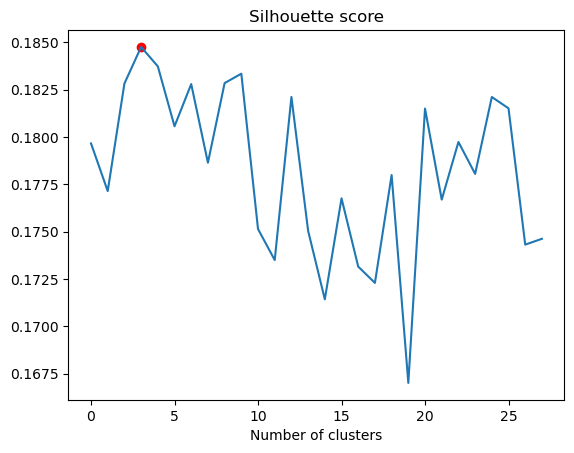



Best cluster in the range 3 to  30 is :  6 , with a silhouette score of:  0.18476316122865447   


firing rate threshold:  2.6921725204705083


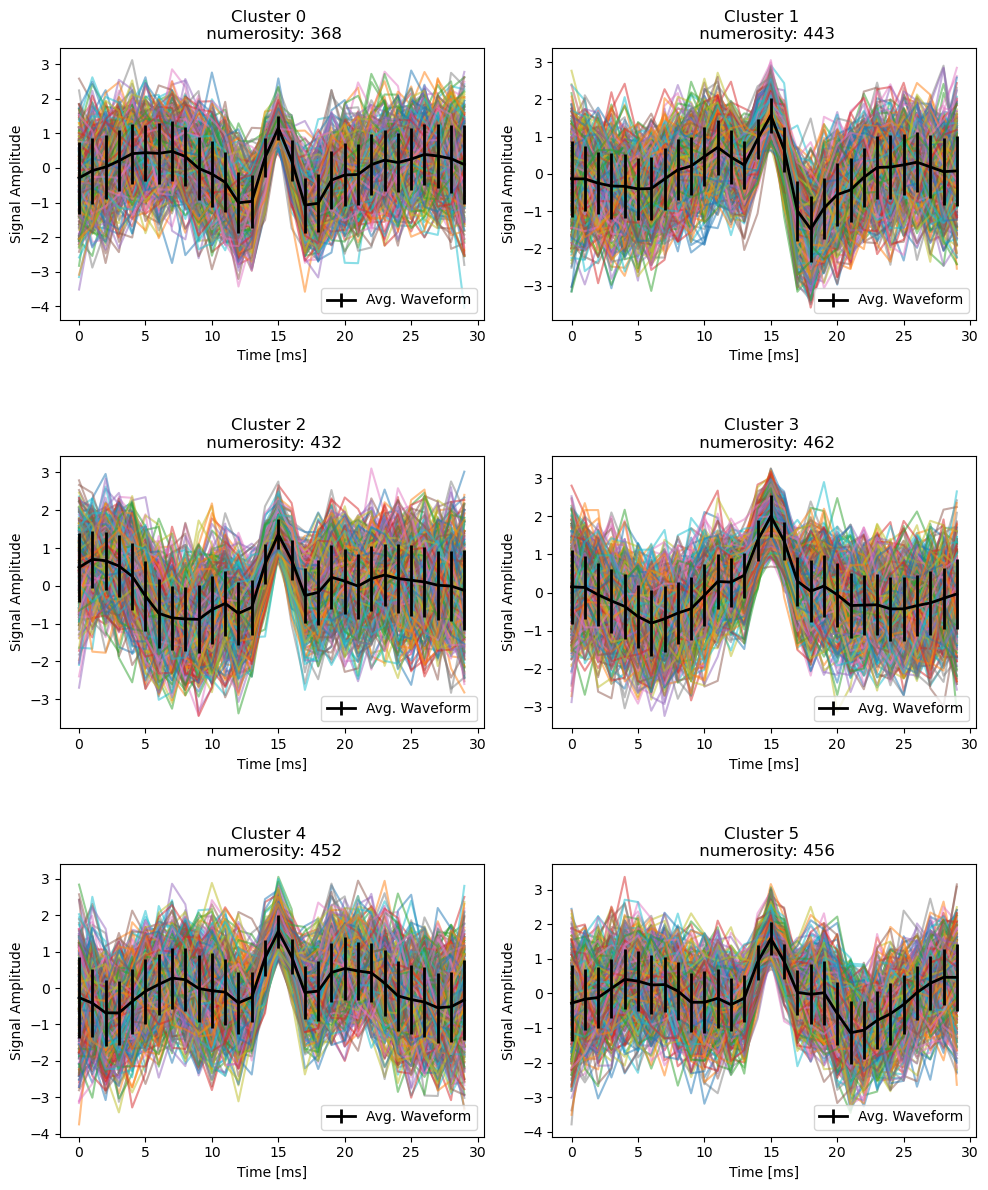

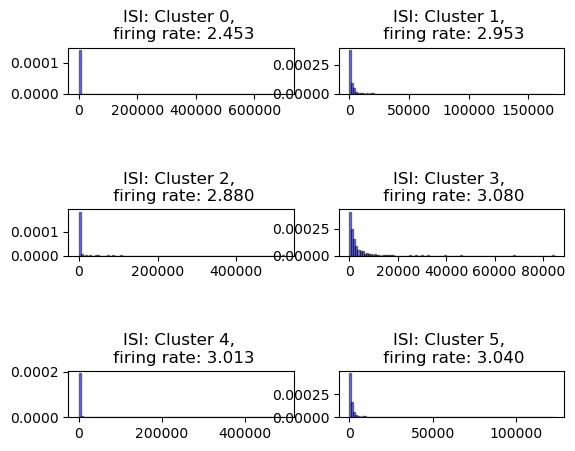

In [12]:
#final_data_pos= nested_clus(pos_cut,'fuzzy',n_pos,merger)
n_min=3
n_max=31
n_comp=4
final_data_pos= bounded_clus(n_comp,n_min,n_max,pos_cut,'kmeans',n_pos,merger)

In [13]:
len(final_data_pos)

5

In [28]:
len(final_data_pos)

20

In [11]:
len(final_data_pos)

16

Total spikes:  4305
For 2 clusters, the silhouette score is: 0.185
For 3 clusters, the silhouette score is: 0.165
For 4 clusters, the silhouette score is: 0.158
For 5 clusters, the silhouette score is: 0.125
For 6 clusters, the silhouette score is: 0.148
For 7 clusters, the silhouette score is: 0.124
For 8 clusters, the silhouette score is: 0.113
For 9 clusters, the silhouette score is: 0.116
For 10 clusters, the silhouette score is: 0.118


Best cluster in the range 2 to  10 :  2 , with a silhouette score of:  0.1845701249049692   


firing rate threshold:  0.08


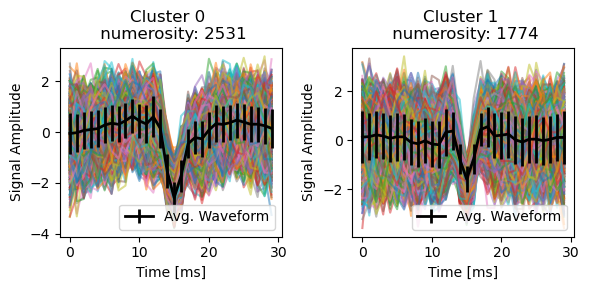

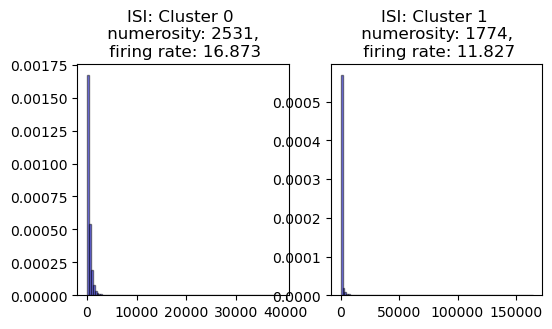

flag:  0
2531 1774
flag:  0
flag:  0
first sub-clustering, count:  1
Total spikes:  2531
For 2 clusters, the silhouette score is: 0.131
For 3 clusters, the silhouette score is: 0.118
For 4 clusters, the silhouette score is: 0.116
For 5 clusters, the silhouette score is: 0.111
For 6 clusters, the silhouette score is: 0.109
For 7 clusters, the silhouette score is: 0.116
For 8 clusters, the silhouette score is: 0.114
For 9 clusters, the silhouette score is: 0.117
For 10 clusters, the silhouette score is: 0.118


Best cluster in the range 2 to  10 :  2 , with a silhouette score of:  0.1312196982966449   


firing rate threshold:  0.08


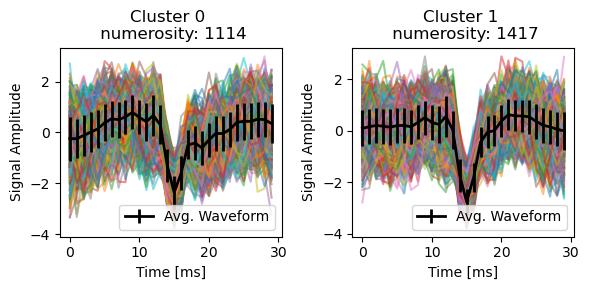

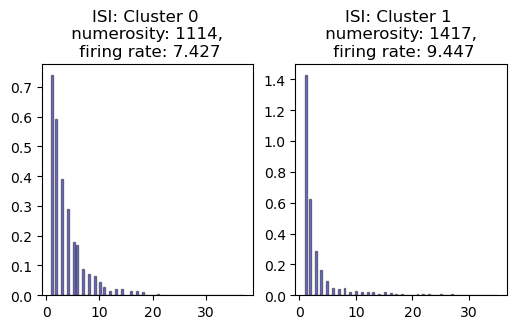

flag:  0
1114 1417
flag:  0
flag:  1
first sub-clustering, count:  2
Total spikes:  1114
For 2 clusters, the silhouette score is: 0.135
For 3 clusters, the silhouette score is: 0.122
For 4 clusters, the silhouette score is: 0.117
For 5 clusters, the silhouette score is: 0.119
For 6 clusters, the silhouette score is: 0.125
For 7 clusters, the silhouette score is: 0.115
For 8 clusters, the silhouette score is: 0.117
For 9 clusters, the silhouette score is: 0.118
For 10 clusters, the silhouette score is: 0.124


Best cluster in the range 2 to  10 :  2 , with a silhouette score of:  0.13460303395953194   


firing rate threshold:  0.08


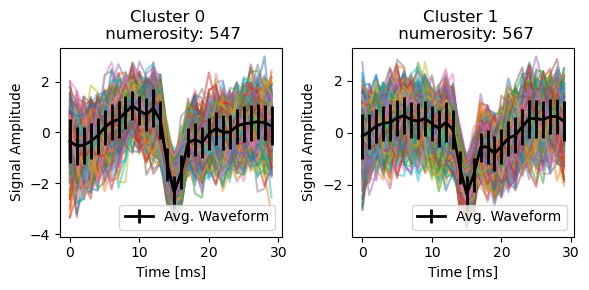

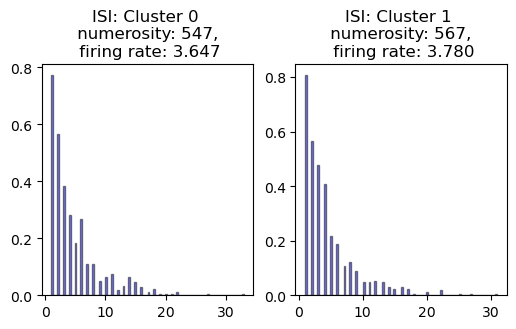

flag:  1
flag:  1 kmeans
second sub-clustering, count:  0
Total spikes:  1417
For 2 clusters, the silhouette score is: 0.135
For 3 clusters, the silhouette score is: 0.123
For 4 clusters, the silhouette score is: 0.122
For 5 clusters, the silhouette score is: 0.114
For 6 clusters, the silhouette score is: 0.112
For 7 clusters, the silhouette score is: 0.116
For 8 clusters, the silhouette score is: 0.113
For 9 clusters, the silhouette score is: 0.114
For 10 clusters, the silhouette score is: 0.112


Best cluster in the range 2 to  10 :  2 , with a silhouette score of:  0.13535638431621963   


firing rate threshold:  0.08


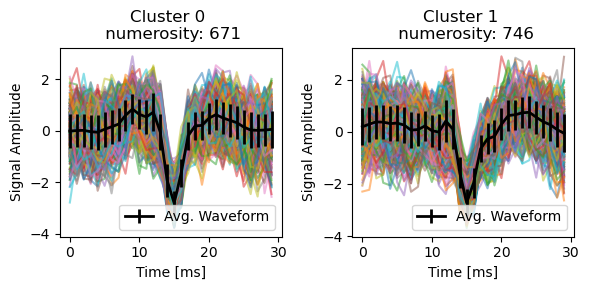

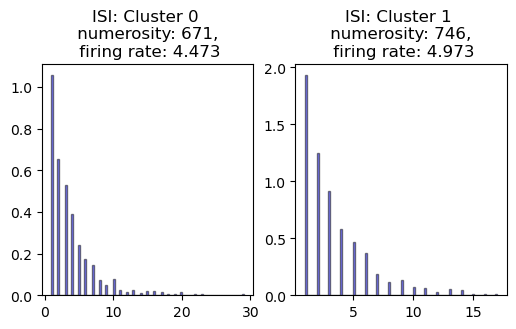

flag:  1
flag:  1 kmeans
flag:  0 kmeans
second sub-clustering, count:  0
Total spikes:  1774
For 2 clusters, the silhouette score is: 0.138
For 3 clusters, the silhouette score is: 0.125
For 4 clusters, the silhouette score is: 0.123
For 5 clusters, the silhouette score is: 0.118
For 6 clusters, the silhouette score is: 0.121
For 7 clusters, the silhouette score is: 0.127
For 8 clusters, the silhouette score is: 0.117
For 9 clusters, the silhouette score is: 0.121
For 10 clusters, the silhouette score is: 0.129


Best cluster in the range 2 to  10 :  2 , with a silhouette score of:  0.1379189749677031   


firing rate threshold:  0.08


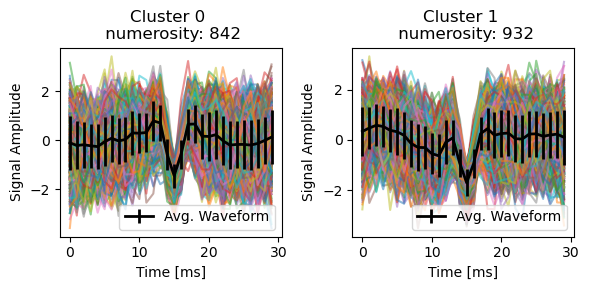

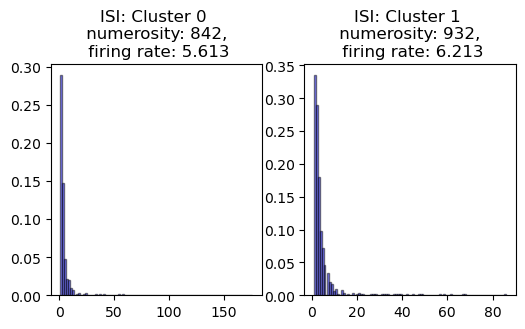

flag:  0
842 932
flag:  0
flag:  1
first sub-clustering, count:  1
Total spikes:  842
For 2 clusters, the silhouette score is: 0.126
For 3 clusters, the silhouette score is: 0.117
For 4 clusters, the silhouette score is: 0.123
For 5 clusters, the silhouette score is: 0.127
For 6 clusters, the silhouette score is: 0.123
For 7 clusters, the silhouette score is: 0.128
For 8 clusters, the silhouette score is: 0.124
For 9 clusters, the silhouette score is: 0.128
For 10 clusters, the silhouette score is: 0.126


Best cluster in the range 2 to  10 :  7 , with a silhouette score of:  0.12797988199002305   




/Users/Gaia_1/Desktop/tesi/NewLibraryENG.py:468: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


firing rate threshold:  0.08


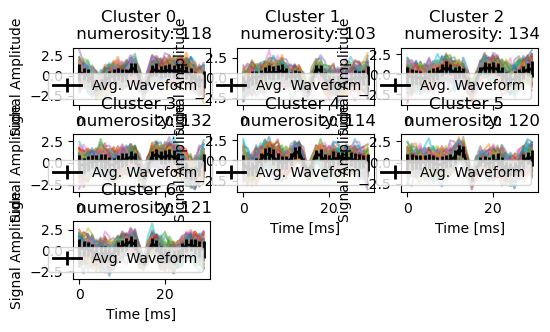

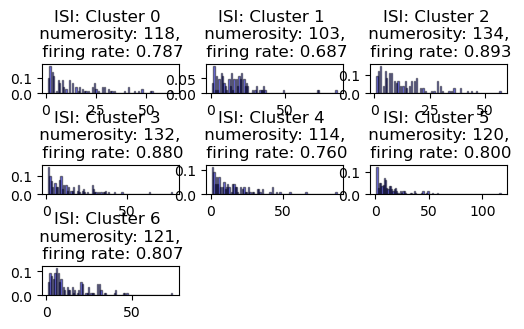

flag:  1
flag:  1 kmeans
second sub-clustering, count:  0
Total spikes:  932
For 2 clusters, the silhouette score is: 0.127
For 3 clusters, the silhouette score is: 0.117
For 4 clusters, the silhouette score is: 0.120
For 5 clusters, the silhouette score is: 0.116
For 6 clusters, the silhouette score is: 0.119
For 7 clusters, the silhouette score is: 0.124
For 8 clusters, the silhouette score is: 0.122
For 9 clusters, the silhouette score is: 0.128
For 10 clusters, the silhouette score is: 0.125


Best cluster in the range 2 to  10 :  9 , with a silhouette score of:  0.12819081550156197   




/Users/Gaia_1/Desktop/tesi/NewLibraryENG.py:468: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


firing rate threshold:  0.08


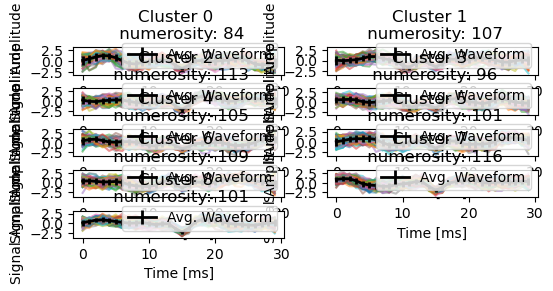

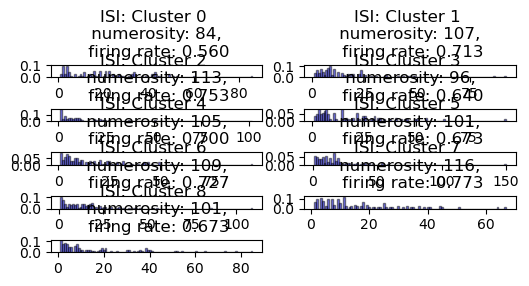

flag:  1
flag:  1 kmeans
flag:  0 kmeans


In [14]:
final_data_neg= nested_clus(neg_cut,'kmeans',n_neg,merger)
#n_min=1
#n_max=31
#final_data_neg= bounded_clus(n_comp,n_min,n_max,neg_cut,'kmeans',n_neg,merger)

In [15]:
len(final_data_neg)

20

In [31]:
len(final_data_neg)

20

In [16]:
len(final_data_neg)

79

In [16]:
neurons=[]
final_data=final_data_pos
for arr in final_data:
    if len(arr)<30:
        for el in arr:
            neurons.append(el)
    else:
        neurons.append(arr)
final_data=final_data_neg
for arr in final_data:
    if len(arr)<5:
        for el in arr:
            neurons.append(el)
    else:
        neurons.append(arr)
print('len',len(neurons))

len 25


In [17]:
neurons[9]

array([  21,   33,   57,   81,  125,  129,  157,  163,  191,  198,  202,
        220,  222,  240,  265,  271,  283,  285,  287,  288,  311,  314,
        320,  343,  352,  354,  395,  400,  408,  417,  420,  437,  441,
        453,  455,  476,  477,  480,  484,  515,  528,  541,  544,  559,
        560,  623,  647,  680,  687,  733,  745,  773,  796,  798,  802,
        803,  806,  821,  825,  833,  835,  839,  851,  863,  883,  893,
        894,  896,  904,  908,  915,  944,  947,  981,  984, 1023, 1031,
       1032, 1040, 1047, 1054, 1083, 1099, 1124, 1126, 1128, 1141, 1193,
       1199, 1212, 1260, 1275, 1278, 1326, 1327, 1336, 1346, 1377, 1380,
       1409, 1426, 1428, 1460, 1468, 1521, 1540, 1564, 1566, 1572, 1613,
       1616, 1622, 1648, 1672, 1689, 1691, 1732, 1745])

neurons = []
for neuron in final_data_pos:
    neurons.append(neuron)
for neuron in final_data_neg:
    neurons.append(neuron)
neurons

neur:  23 116


(array([12.,  8.,  6.,  9.,  7.,  3., 11.,  9.,  2.,  3.,  3.,  2.,  7.,
         3.,  1.,  2.,  1.,  1.,  5.,  1.,  1.,  2.,  0.,  1.,  3.,  1.,
         0.,  2.,  1.,  1.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.0001  , 0.000232, 0.000364, 0.000496, 0.000628, 0.00076 ,
        0.000892, 0.001024, 0.001156, 0.001288, 0.00142 , 0.001552,
        0.001684, 0.001816, 0.001948, 0.00208 , 0.002212, 0.002344,
        0.002476, 0.002608, 0.00274 , 0.002872, 0.003004, 0.003136,
        0.003268, 0.0034  , 0.003532, 0.003664, 0.003796, 0.003928,
        0.00406 , 0.004192, 0.004324, 0.004456, 0.004588, 0.00472 ,
        0.004852, 0.004984, 0.005116, 0.005248, 0.00538 , 0.005512,
        0.005644, 0.005776, 0.005908, 0.00604 , 0.006172, 0.006304,
        0.006436, 0.006568, 0.0067  ]),
 <BarContainer object of 50 artists>)

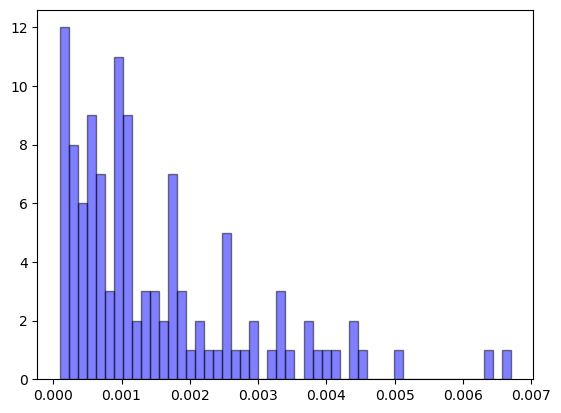

In [19]:
x=randint(0,len(neurons)-1)
print('neur: ',x,len(neurons[x]))
data_healthy=neurons[x]
ISI_healthy = np.diff(data_healthy)/10000
plt.hist(ISI_healthy, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

(array([182., 115.,  33.,  41.,  19.,  14.,  13.,   2.,   4.,   1.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1. ,  2.6,  4.2,  5.8,  7.4,  9. , 10.6, 12.2, 13.8, 15.4, 17. ,
        18.6, 20.2, 21.8, 23.4, 25. , 26.6, 28.2, 29.8, 31.4, 33. , 34.6,
        36.2, 37.8, 39.4, 41. , 42.6, 44.2, 45.8, 47.4, 49. , 50.6, 52.2,
        53.8, 55.4, 57. , 58.6, 60.2, 61.8, 63.4, 65. , 66.6, 68.2, 69.8,
        71.4, 73. , 74.6, 76.2, 77.8, 79.4, 81. ]),
 <BarContainer object of 50 artists>)

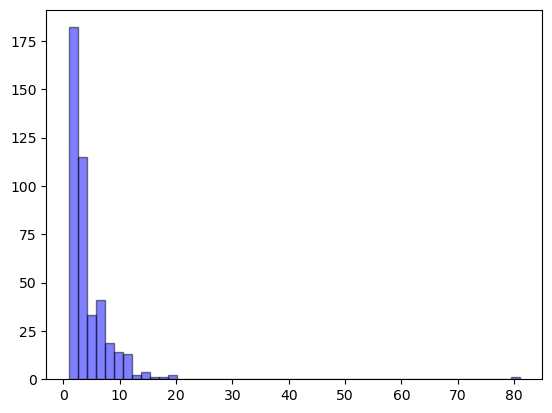

In [59]:
locs_diff=np.diff(data_healthy)
#plt.axis([-3,500,0,0.05])
plt.hist(locs_diff, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

## Point Process

In [20]:
ISI_data=ISI_healthy

In [21]:
map_estimate,ppc_trace= Bayesian_mixture_model(ISI_healthy)

Sequential sampling (1 chains in 1 job)
NUTS: [mu1, lam1, mu2, sigma2, mu3, sigma3, w]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 31 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [like]


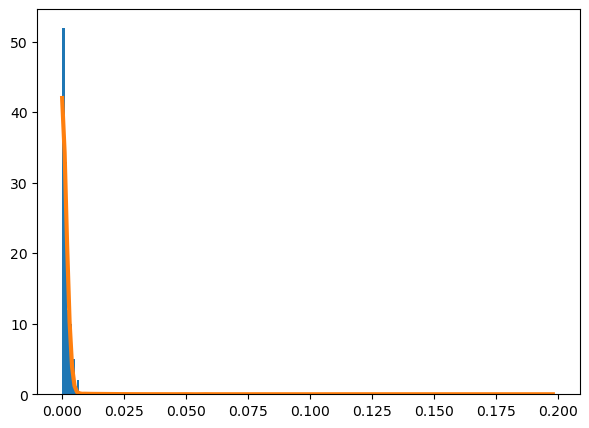

In [30]:
#with model:
#    ppc_trace = pm.sample_posterior_predictive(trace,model=model)

bins = np.arange(0, .2, 1e-3) 
plt.figure (figsize=(7,5))

hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
#plt.axis([-0.01,0.13,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [31]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

In [36]:
len(counts)
#len(bins)

199

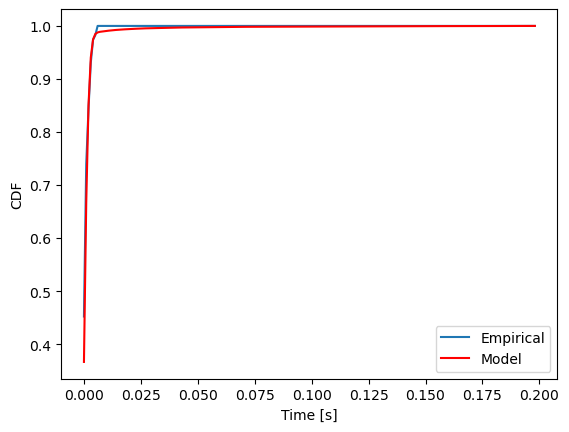

In [33]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

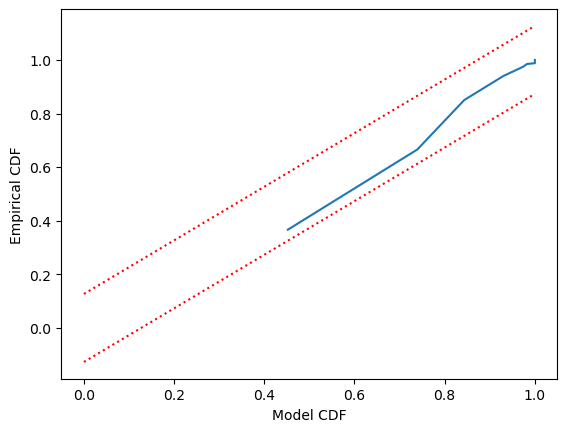

In [34]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
#plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

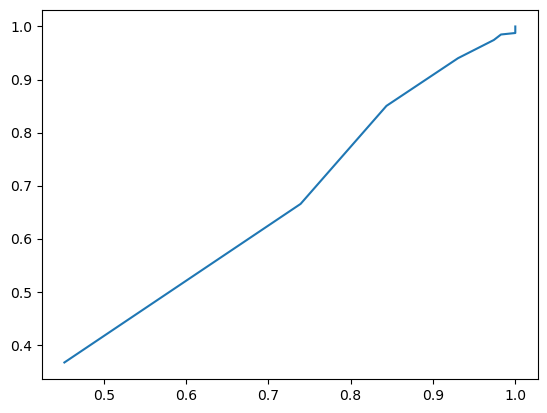

In [35]:
#plt.plot(Femp)
#plt.plot(Fmodel)
plt.plot(Femp,Fmodel)

In [ ]:
map_estimate = pm.find_MAP(model=model)
del map_estimate['w_simplex__']
del map_estimate['mu1_interval__']
del map_estimate['lam1_interval__']
del map_estimate['mu2_interval__']
del map_estimate['sigma2_interval__']
del map_estimate['mu3_interval__']
del map_estimate['sigma3_interval__']

map_estimate['w1'] = map_estimate['w'][0]
map_estimate['w2'] = map_estimate['w'][1]
map_estimate['w3'] = map_estimate['w'][2]

del map_estimate['w']


map_estimate

In [ ]:
dataframe = pd.DataFrame()
list_neurons = adj_neur
counter=0
print('Original number of neurons: ',len(list_neurons))
for neuron in list_neurons:
    neuron=neuron[neuron>0*10000]
    neuron=neuron[neuron<200*10000]
    print('  Neuron with ',neuron.shape[0],'spikes')
    if neuron.shape[0]>1000:

        counter+=1
    else:
        print('    Excluded neuron with n spikes = ',neuron.shape[0])
        continue

    ISI_healthy = np.diff(neuron)/10000


    map_estimate = Bayesian_mixture_model(ISI_healthy)

    df = pd.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pd.concat([dataframe,df],axis = 1)
print('Final number of neurons: ',counter)
print('Target = ',target)

In [ ]:
final = dataframe.T
final.to_csv('Data after PP/DataAfter')

## Classification

In [ ]:
def performance_visualizer(trials_obj,n_models,choice=False,**choice_var):
    
    import pandas as pd
    
    performance = [1-t['result']['loss'] for t in trials_obj.trials]
    
    
    hyperparam= list(trials_obj.trials[0]['misc']['vals'].keys())
    
    values_dict ={}
    
    for i in hyperparam:
        
        values_dict[i]=[]
        
        for j in trials_obj.trials:
            
            if(len(j['misc']['vals'][i])==0):
                
                values_dict[i].append(np.NaN)
                
            else:
            
                values_dict[i].append(j['misc']['vals'][i][0])
                
    out = pd.DataFrame.from_dict(values_dict)
    
    out['performance'] = performance
    
    out=out.sort_values(by=['performance'])
    
    
    if choice:
        
        for i in list(choice_var.keys()):
        
            for j,_ in enumerate(choice_var[i]):
        
                out[i]=out[i].replace(j,choice_var[i][j])
    
    return out.tail(n_models)

In [ ]:
dataset = pd.read_csv('Data after PP/Data')
dataset = dataset.drop(['Unnamed: 0'],axis=1)
dataset